# Case inhousedag KPMG 

As stated in the case description Raduga Inc. wants to know how much colors it has to make for the world cup 2018. Part of this big project is a simulation of the upcomming tournament. They want to have a statistical substantiated estimation. The simulation part of the project is given to the Business Analytics and the Advanced Analytics & Big Data teams of KPMG. Your mission is to write this simulation. 

The Data Management team has some data available for you.  You may use any other data source you might think is useful for your prediction and simulation. 

## High over suggested code setup and points distribution
You may build up your code in any way you want. The core coding language used at KPMG is python, but for this 'simple' simulation you may use any language you are comfortable with. All tips and tricks will however be provided in python. 

In this notebook you will find a skeleton of the code which you could use. Altough a lot of code is ready to use, there is a need to edit the code in some places. These places are indicated by "CODE_IT_YOURSELF". When you are finished editing the code at all the CODE_IT_YOURSELF-places, you have a simplified simulation of a World Cup tournament ready. This simplified simulation does not take into account all the specifics of an official tournament. Several improvements can be made. Suggestions of improvements are given at the bottom of this notebook.

Note that it is possible to buy complete blocks of code. The functionality of the different code-blocks and the prices are shown below.

### Exploration (15k)
* Look into the data what elements does it have 
* what are the relevant variables for the simulation 
* Can you find a function to describe the data? 

### Data cleaning (25k)
* You can choose to hire an external party to clean up your data.

### Simulation (85k)
**Tip:**
Build up your code in a way that you can simulate chunks of the bigger simulation.
For example:

#### knock out phase (25k)
* single match with 50/50 chance for knock-outphase 
* single round of the knock-out phase 
    * make random pairs to match them up (lottery like) 
* complete knock-out phase 

#### group phase (25k)
* single match with 50/50 chance for group phase 
* a way to keep track of the scores in the group phase 
* make a round of the group phase 
* complete simulation of the group phase 
* how to extract the winner and follow-up in the group phase 

#### weighting factor and final results (25k) 
* introduce a weighting factor between the teams from external data (historical), for a suggestion see below 
* combine groupphase and knockout to a complete tournament 
* make a way to keep track of tournament results 

#### Color distribution based on simulation results (10k) 
* develop a method to determine the color distribution needed 

### Simulation results (100k) 
* In case you get completely stuck, we offer you the possibility to buy our simulation result. This is considered a last resort in case you get completely stuck and will provide you the possibility to focus entirely on the other issues this client faces. It is however a very poor way to handle your resources.(100k)

##### Weighting factor
A suggestion for the weighting factor is down below. If you have improvements or other suggestions feel free to implement them. 

This can give bonus scores!
If $rank_A > rank_B$ then:

$P(A_{wins}) = \frac{1}{\sqrt{\log_2(\mid rank_B-rank_A\mid+1)}}$

else:

$P(A_{wins}) = 1 - \frac{1}{\sqrt{\log_2(\mid rank_B-rank_A\mid+1)}}$


# Important: Document and present your way of thinking and the changes and improvements you have made

## Import of all usefull packages

In [1]:
# =====================================================================================
# DO ALL YOUR DATA PREPARATION AND ANALYSIS in this file
# =====================================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import random
import itertools
from scipy.optimize import curve_fit
from scipy.misc import factorial
import os
import pylab as pylab
%matplotlib inline

# set the right enviroment variable to the data
#filepath = os.chdir('/home/bschermer/Documents/Inhousedag')
filepath = os.chdir('./')


# Data exploration

### loading the data into your memory

In [2]:
# ___________________________________________________________________________
# load in the data files to a pandas dataframe
fifa_ranking = pd.read_csv('Fifa_ranking_new.csv', sep=';')
games = pd.read_csv('matches.csv', sep=';')
participants = pd.read_csv('Participating_Countries.csv', sep=';')

print('The first 5 lines of the fifa ranking file')
print(fifa_ranking.head(), '\n')
print('The first 5 lines of the matches file')
print(games.head(), '\n')
print('The first 5 lines of the Participating countries file')
print(participants.head(), '\n')

The first 5 lines of the fifa ranking file
        Date            Team  Rank  Score  Unnamed: 4
0  20-5-1998          Brazil     1     71         NaN
1  20-5-1998         Germany     2     64         NaN
2  20-5-1998  Czech Republic     3     64         NaN
3  20-5-1998          Mexico     4     61         NaN
4  20-5-1998         England     5     60         NaN 

The first 5 lines of the matches file
     Team 1       Team 2  DP_team1  DP_team2  year
0    Brazil      Croatia         3         1  2014
1    Mexico     Cameroon         1         0  2014
2     Spain  Netherlands         1         5  2014
3     Chile    Australia         3         1  2014
4  Colombia       Greece         3         0  2014 

The first 5 lines of the Participating countries file
   Year         Team  Red  Yellow  Blue  Green  White  Black Group
0  2014    Australia  0.0     0.0   0.0    0.0    0.0    0.0   NaN
1  2014         Iran  0.0     0.0   0.0    0.0    0.0    0.0   NaN
2  2014        Japan  0.0     

### make a list of countries that are participating this year
This is what you might need as input later on for your algorithm to simulate the matches

In [3]:
# ___________________________________________________________________________
# create the team list which you can fill in in the tournament simulation
team_list = list(participants['Team'][participants['Year'] == 2018])

print(team_list)

['Russia', 'Brazil', 'Iran', 'Japan', 'Mexico', 'Belgium', 'South Korea', 'Saudi Arabia', 'Germany', 'England', 'Spain', 'Nigeria', 'Costa Rica', 'Poland', 'Egypt', 'Iceland', 'Serbia', 'Portugal', 'France', 'Uruguay', 'Argentina', 'Colombia', 'Panama', 'Senegal', 'Morocco', 'Tunisia', 'Switzerland', 'Croatia', 'Sweden', 'Denmark', 'Australia', 'Peru']


### Get the sum of the amount of goals scored in each match
This is important to know for the analysis of which distribution to use in the simulation later on

     Team 1       Team 2  DP_team1  DP_team2  year  sum
0    Brazil      Croatia         3         1  2014    4
1    Mexico     Cameroon         1         0  2014    1
2     Spain  Netherlands         1         5  2014    6
3     Chile    Australia         3         1  2014    4
4  Colombia       Greece         3         0  2014    3


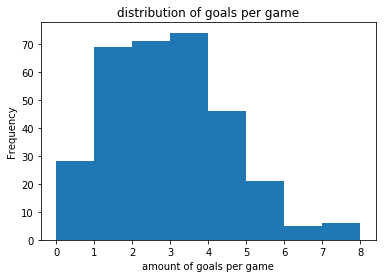

In [4]:
# ___________________________________________________________________________
# create the distribution of goals per match
games['sum'] = games['DP_team1'] + games['DP_team2']

print(games.head())
games['sum'].plot(kind='hist', bins=8, title='distribution of goals per game')
plt.xlabel('amount of goals per game')
plt.show()

## Analysis distribution of amount of goals per game
The goal of the next part is to find a statistical distribution which fits the histogram of amount of goals per game. When one knows this distribution one is able to randomly draw later on from this distribution. This randomly drawn number is then the amount of goals that will be scored in a game. If you know the amount of goals scored in a game one only has to distribute them between the teams.  
So below we will select a few years of data to train on and one can do a validation on the data that is not used. 
There are two ways to find the distribution that is via calculating the mean directly or fitting a distribution to the data. 

The years available in the dataset are [2014 2010 2006 2002 1998]


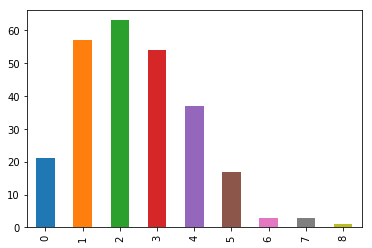

In [5]:
#  __________________________________________________________________________
# find out how many years of data you have and put them in a list
# this can be usefull for selecting the data you want to use in your 
# selection of the kind of distribution for the goals per game you want to
# use in your simulation 
table = games['year'].unique()
print('The years available in the dataset are', table)


# ===========================================================================
# Analysis distribution goals per game
# ===========================================================================
def goals_per_game(game):
    """
        Count how many times a certain amount of goals in a game occurs.
    """
    return game['sum'].value_counts()

# __________________________________________________________________________________
# take only the year 2010, 2006, 2002, 1998 as input for the analysis
# so that 2014 can be used as a validation set
df = pd.DataFrame()
for i in table[1:]:
    df = df.append(goals_per_game(games[games['year'] == i]).sort_index())

# __________________________________________________________________________________
# transpose the data frame
df = df.T
data = df.sum(axis=1)

# __________________________________________________________________________________
# how does the data look like?
data.sort_index().plot(kind='bar')

## CODE_IT_YOURSELF: Now fit a statistical distribution to the data
Further in the script you might need to draw a random number from a distribution to determine a the number of goals which occur in a game. 

### To do:
- Think about which distribution describes the data best. **hint: one can think of gaussian, normal, poisson, binomial, uniform etc...**
- Determine the shape parameters of the distribution. One could do one of the following:
  - Fit the distribution to the data. **hint: use the data in the variable "data" as define in the above code block**
  - Calculate the shape parameters from the games data directly and plot the distribution on top of the data to visually assess whether the distribution is correct. **hint: use the data in the dataframe "games"**

  

In [6]:
# CODE_IT_YOURSELF: Your first task -- Fit a statistical distribution!




# Now make the functions needed to do the simulation



## Knock out phase
We have chosen to simulate first the knock-out fase because it is easier to implement. It is easier because you have to implement less conditions. The main conditions for the knock-out phase are:

- A single game has only a winner and a loser no even match
- The number of goals only determines who the winner is; points do not have to be given
- There are 16 teams start at the knock-out phase

We have simulated the knock-out phase is several steps:
* Create a function for a single match between two teams
* Two teams who are asigned to play against each other are called a pair
* For a playing round, 
   * first all pairs are made
   * then the round is 'played' and it is determined which teams will move on to the next round
   * the winning teams are then input for the next round
   * repeat this till you have determined a winner of the tournament

An extra implementation that can be made is to implement a certain weight to distributing the goals in a single match. As stated before we say that if the number 1 of the fifa ranking plays against the number 40 it is more likely that the number 1 will score and win.  
**For simplification it might be easier to start with a non-weighted model (50:50 chance between teams).** 

### A single game
- For now, assume that the total number of goals scored in a game is a given number. (Later this number can be chosen at random from the distribution of goals you have found before)
- It is important in a single game to think about how to assign goals to a certain team (draw randomly from a distribution?)
- How do you deterime when a team wins or loses a game?
- How do you keep track of the winner? How would you implement this in the knock-out phase?

It is recommended to read te code below. In this code you need to add yourself:
- Distribution of the goals between the teams

In [8]:

# --- calculates how many goals are scored per team
def wed(dp, pair, weight):
    """ Simulates the results of a game between two teams
        dp --> amount of goals in a game
        pair --> the two teams playing the game
        weight --> what is the difference in strength between the teams
        The difference in strength is expressed in a num between 0 and 1
        Where if 1, team 1 is absolutely the strongest
    """
    team1_wins = False
    team1 = pair[0]
    team2 = pair[1]
    t1_goals = #CODE_IT_YOURSELF: FILL IN A METHOD OF HOW TO DISTRIBUTE THE GOALS IN THE MATCH BETWEEN THE TEAMS
    t2_goals = dp - t1_goals
    # --- determine who wins
    if t1_goals > t2_goals:
        team1_wins = True
    elif t1_goals < t2_goals:
        team1_wins = False
    # --- when the scores are even then flip a coin
    else:
        if np.random.binomial(1, 0.5) == 1:
            team1_wins = True
    # --- pass on the results
    if team1_wins:
        win = team1
    else:
        win = team2
    return [[t1_goals, t2_goals], win]

# =======================================================
# example of a single match
# =======================================================

pair_example = ['team1', 'team2']
dp_example = 3
weight_example = 0.5

print('the results of playing a single match')
for i in range(5):
    print(wed( dp_example, pair_example, weight_example))

the results of playing a single match
[[2, 1], 'team1']
[[0, 3], 'team2']
[[2, 1], 'team1']
[[1, 2], 'team2']
[[1, 2], 'team2']


### making pairs

Now we are going scale up. We dont have two teams any more but actually 16. We need to make pairs out of them so that they match up. We need to keep in mind that it has to modular during the simulation, because for each round of the knock-out phase half of the teams will drop out.  
** Note: For now we choose to randomly shuffle the teams and then pair them up for simplification**. This is a simplification with respect to an offcial tournament where the pairs of the teams are determined by the results of the group phase. 

The input of the algorithm is a list of teams.

In [9]:
# --- first simulate a knock-out tournament
def pairs(teams_list):
    """ Simulates the randomness in the teams"""
    # --- shuffle the team_list for randomness
    random.shuffle(teams_list)
    pair_list = []
    while len(teams_list) > 0:
        pair = teams_list[0], teams_list[1]
        pair_list.append(pair)
        # --- remove the paired teams from the list
        del teams_list[0]
        del teams_list[0]
    return pair_list


# =======================================================
# example of making pairs
# =======================================================

team_list_example = ['team1',
                     'team2',
                     'team3',
                     'team4',
                     'team5',
                     'team6',
                     'team7',
                     'team8',
                     'team9',
                     'team10',
                     'team11',
                     'team12',
                     'team13',
                     'team14',
                     'team15',
                     'team16']
print('Example of pairs that are made for the first round of the simulation')
pairs(team_list_example)

Example of pairs that are made for the first round of the simulation


[('team15', 'team1'),
 ('team16', 'team10'),
 ('team6', 'team3'),
 ('team7', 'team4'),
 ('team13', 'team12'),
 ('team14', 'team8'),
 ('team5', 'team9'),
 ('team11', 'team2')]

## Play a single round of the knock-out phase

The next step is to play a single round in the knock out phase. For the first round this means there have to be 8 matches, second round 4 etc. Therefore, the algorithm does has to be flexible about the different sizes of team lists.

It is reccomended to read the code below. You need to add yourself:
- Think about how to get the total number of goals in a single game. **Hint: look back at the distribution you found in the exploration**
- Optional: add the weighting between the strenght of two teams into the algorithm. **Hint: do this at a later time and proceed first with weighting = False (see example)**. When you which to add weighting betweeen the two teams you need to set weighting=True and add your own do where CODE_IT_YOURSELF is indicated.

In [13]:
def play_round(teams_list, weighting = False):
    """ Calculates a play round of the tournament in the knockout phase"""
    
    # make a list of all the goals which will be scored this round
    dp = # CODE_IT_YOURSELF: MAKE HERE YOUR CODE TO DETERMINE THE TOTAL NUMBER OF GOALS ARE SCORED IN A GAME. 
    # THE VARIABLE dp SHOULD BE A LIST OF ALL TOTAL GOALS FOR EACH MATCH IN A PLAY-ROUND. FOR EXAMPLE, IF THERE ARE
    # 8 MATCHES (BETWEEN 16 TEAMS), THEN dp SHOULD HAVE LENGTH 8.
    
    # make the pairs for this round
    pairs_list = pairs(teams_list)
    # create two lists to save the data from the match
    # result will keep track of the amount of goals in the match
    # win will keep track of who is the winner
    result = []
    win = []
    # --- simulates the games between pairs
    for i, pair in enumerate(pairs_list):
        if weighting is True:
            weight = # CODE_IT_YOURSELF: THINK OF YOUR WEIGHTED FUNCTION HERE
        else:
            weight = 0.5
        game_res = wed(dp[i], pair, weight)
        result.append(game_res[0])
        win.append(game_res[1])
    return {'teams': pairs_list, 'uitlag': result, 'winst': win}

# =======================================================
# example of play round
# =======================================================

team_list_example = ['team1',
                     'team2',
                     'team3',
                     'team4',
                     'team5',
                     'team6',
                     'team7',
                     'team8',
                     'team9',
                     'team10',
                     'team11',
                     'team12',
                     'team13',
                     'team14',
                     'team15',
                     'team16']

print('results of a single example playround')
# Take notice that weighting is set to false but in the end
# you will want to use this to properly distribute the goals 
# between teh teams
play_round(team_list_example, weighting=False)

results of a single example playround


{'teams': [('team2', 'team9'),
  ('team11', 'team1'),
  ('team6', 'team13'),
  ('team3', 'team10'),
  ('team7', 'team16'),
  ('team4', 'team15'),
  ('team12', 'team5'),
  ('team14', 'team8')],
 'uitlag': [[2, 2], [2, -1], [0, 1], [1, 0], [3, 0], [1, 0], [1, 2], [1, 2]],
 'winst': ['team2',
  'team11',
  'team13',
  'team3',
  'team7',
  'team4',
  'team5',
  'team8']}

### Now simulate a complete knock out phase 
The input of the knock out phase is a list of teams who continue after the groupphase. Since we have not modelled the groupphase yet, we assume that the input of the knock out phase is a list of 16 teams.

The knock out phase algorithm outputs a dataframe where each column is a play round. The values are the teams that are playing in the round. The last column contains only one team. This team is the winner.

In [14]:
def knockout(teams_list, weighting = False):
    """
        Calculates the knockout phase of the tournament, like a random tournament
        :param team_list: list of teams that get to the knockout phase
        :return: a dataframe is returned with the results of the knockout phase
    """
    amount_of_teams = len(teams_list)

    # --- how many rounds do we need to play??
    rounds = int(np.log(amount_of_teams) / np.log(2))
    # --- save the data of round 0
    round_results = [teams_list.copy()]
    # --- simulate the results per round in the tournament
    for i in range(rounds):
        result = play_round(teams_list, weighting)
        # --- updating the team_list
        teams_list = result['winst']
        # --- saving the results of a play_round
        round_results.append(result['winst'].copy())
    return pd.DataFrame(round_results).T

# =======================================================
# example of knock-out phase
# =======================================================

team_list_example = ['team1',
                     'team2',
                     'team3',
                     'team4',
                     'team5',
                     'team6',
                     'team7',
                     'team8',
                     'team9',
                     'team10',
                     'team11',
                     'team12',
                     'team13',
                     'team14',
                     'team15',
                     'team16']

knockout(team_list_example, weighting = False)

,0,1,2,3,4
0,team1,team12,team2,team13,team2
1,team2,team2,team7,team2,None
2,team3,team15,team11,None,None
3,team4,team11,team13,None,None
4,team5,team13,None,None,None
5,team6,team10,None,None,None
6,team7,team5,None,None,None
7,team8,team7,None,None,None
8,team9,None,None,None,None
9,team10,None,None,None,None


# Now we will create Groupphase
The groupphase is more difficult than the knockout phase: ones has to keep track of more statistics about the teams then only who wins a match. After each match points are assigned to the teams. The winner of each group is determined based on the points. Use the following schema do decide on the winners of the group phase:
- The team with the highest balance wins, if even then:
- The team with the most goals in favor wins, if even then:
- Draw a lot to determine which teams advances

One has to take into account the following features which are important for the simulation:
- teams gain points for each game
- teams in a group have to play only a single time against each other
- no penalties
- you need to keep track of both the points and the number of goals per team


## Create a way to save the results for each individual team
The teams are already assigned to a specific group by FIFA. This group can be found in the participants dataset. We need to design a method to keep track of the perfomance of each team. We have chosen to make use of a dictionary to store the results of each game for each team. 

In [15]:
def team_dicts(teams):
    """
    Creates the structure of the data per team to log their scores
    :param teams:
    :return: list of dicts per team
    """
    list_teams = []
    for i in teams:
        group_team = participants['Group'][(participants['Team'] == i) & (participants['Year'] == 2018)].values[0]
        # goals_ag = goals against
        # goals_if = goals in favor
        team_dict = {'team_name': i, 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': group_team}
        list_teams.append(team_dict.copy())
    return list_teams


# ======================================================================
# example of the dictonary to keep track of the performance of each team
# ======================================================================

team_dicts(team_list)

[{'goals_ag': 0,
  'goals_if': 0,
  'group': 'A',
  'points': 0,
  'ranking': 0,
  'team_name': 'Russia'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'E',
  'points': 0,
  'ranking': 0,
  'team_name': 'Brazil'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'B',
  'points': 0,
  'ranking': 0,
  'team_name': 'Iran'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'H',
  'points': 0,
  'ranking': 0,
  'team_name': 'Japan'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'F',
  'points': 0,
  'ranking': 0,
  'team_name': 'Mexico'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'G',
  'points': 0,
  'ranking': 0,
  'team_name': 'Belgium'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'F',
  'points': 0,
  'ranking': 0,
  'team_name': 'South Korea'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'A',
  'points': 0,
  'ranking': 0,
  'team_name': 'Saudi Arabia'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'F',
  'points': 0,
  'ranking': 0,
  'team_name': 'Germany'},
 {'goals_ag': 0,
  'goals_i

## Make groups of four for the groupphase
In the world cup is the group phase made up out of 4 teams competing against each other. For simplification we will chose at the moment just random groups of 4 teams to play-out the groupphase. Keep in mind that the fifa has a more strict version of the groups layout. 

In [16]:
def groups_random(list_teams):
    """
    Shuffles the teams like a drawing of lots in real life and groups the teams in pouls of 4 teams
    :param list_teams: contains the team names
    :return: returns a list of lists, where each list contains the dicts for all teams within a certain group
    """
    random.shuffle(list_teams)
    group_list = []
    # --- groups the teams in blocks of containing 4 teams a block
    while len(list_teams) > 0:
        group = list_teams[0:4]
        group_list.append(group)
        del list_teams[0:4]
    return group_list

# example of the random distrubution of teams in a list of 4 teams which make up the group in the groupphase
groups_random(team_dicts(team_list))

# thus this is expected that the 'group' in the dicts is messed up, because it is random

[[{'goals_ag': 0,
   'goals_if': 0,
   'group': 'C',
   'points': 0,
   'ranking': 0,
   'team_name': 'Peru'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'D',
   'points': 0,
   'ranking': 0,
   'team_name': 'Nigeria'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'G',
   'points': 0,
   'ranking': 0,
   'team_name': 'England'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'E',
   'points': 0,
   'ranking': 0,
   'team_name': 'Brazil'}],
 [{'goals_ag': 0,
   'goals_if': 0,
   'group': 'F',
   'points': 0,
   'ranking': 0,
   'team_name': 'Germany'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'F',
   'points': 0,
   'ranking': 0,
   'team_name': 'South Korea'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'D',
   'points': 0,
   'ranking': 0,
   'team_name': 'Argentina'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'C',
   'points': 0,
   'ranking': 0,
   'team_name': 'Denmark'}],
 [{'goals_ag': 0,
   'goals_if': 0,
   'group': 'H',
   'points': 0,
   'ranking': 0

## Make a single game
As stated above in the groupphase we have to keep track of more features of the teams then only who wins and who loses. This is done in the phase below. 

It is reccomended to read the code. You have to fill in the following:
- weights between the two teams (OPTIONAL)
- distribution of goals between teams **hint how did you do it in the knock-out phase?**
- assign the points to the teams correctly

In [17]:
def game(pair, dp, weighting = False):
    """
    Calculates the results of single match between two teams in the poulphase
    :param pair: The teams which play against each other
    :param dp: The total number of goals scored in the game (integer)
    :return: the results of the teams to update the dicts
    """
    # --- initiate all variables needed for the simulation of a single match
    team1_wins = False
    team2_wins = False
    team1 = pair[0]
    team2 = pair[1]
    if weighting is True:
        weight = # CODE_IT_YOUSELF: MAKE HERE YOUR CODE TO FIND THE WEIGHT BETWEEN THE TEAMS
    else:
        weight = 0.5
    t1_goals = # CODE_IT_YOUSELF: MAKE HERE YOUR CODE OF THE DISTRIBUTION OF GOALS IN THE TEAMS
    t2_goals = dp - t1_goals
    # --- determine who wins
    if t1_goals > t2_goals:
        team1_wins = True
    elif t1_goals < t2_goals:
        team2_wins = True
    # --- set goal score
    team1['goals_if'] += t1_goals
    team2['goals_if'] += t2_goals
    team1['goals_ag'] += t2_goals
    team2['goals_ag'] += t1_goals
    # --- pass on the results
    # CODE_IT_YOUSELF: MAKE HERE YOUR CODE TO ASSIGN THE POINTS TO THE TEAMS CORRECTLY SO UPDATE THE DICTS.
    # UPDATE THE NUMBER OF POINTS IN THE TEAM'S DICTIONARY
    return [team1, team2]


# ======================================================================
# example of a game
# ======================================================================

team1_example = {'team_name': 'team1', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team2_example = {'team_name': 'team2', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
example_team_list = [team1_example, team2_example]
game(example_team_list, 4, weighting= False)

[{'goals_ag': 3,
  'goals_if': 1,
  'group': 'test',
  'points': 0,
  'ranking': 0,
  'team_name': 'team1'},
 {'goals_ag': 1,
  'goals_if': 3,
  'group': 'test',
  'points': 0,
  'ranking': 0,
  'team_name': 'team2'}]

## Play all the games in a certain group
The next step in the simulation is to create a model that plays the games in a single group. 

Read below and understand the following step:
- It is important that all teams in a group play a single time against each other. no more no less 

It is recommended to read the code. You need to add to the code:
- distribution of goals in a single match 

In [19]:
def games(group):
    """ Calculates the matches of an individual group
        :parameter list group: a list of dictionaries where each dictionary contains info of one team
        :returns the updated list with dictionaries
    """
    # --- which matches need to be played. Find all possible combinations of the four teams
    matches = itertools.combinations(group, 2)
    # --- calculate the results of each match
    for match in matches:
        dp = # CODE_IT_YOURSELF: TOTAL NUMBER OF GOALS IN A SINGLE MATCH.   
        game(match, dp)
    return group

# ======================================================================
# example of alle games within one group
# ======================================================================

team1_example = {'team_name': 'team1', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team2_example = {'team_name': 'team2', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team3_example = {'team_name': 'team3', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team4_example = {'team_name': 'team4', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
example_group = [team1_example, team2_example, team3_example, team4_example]
res = games(example_group)
res

[{'goals_ag': 3,
  'goals_if': 2,
  'group': 'test',
  'points': 0,
  'ranking': 0,
  'team_name': 'team1'},
 {'goals_ag': 1,
  'goals_if': 3,
  'group': 'test',
  'points': 0,
  'ranking': 0,
  'team_name': 'team2'},
 {'goals_ag': 1,
  'goals_if': 1,
  'group': 'test',
  'points': 0,
  'ranking': 0,
  'team_name': 'team3'},
 {'goals_ag': 1,
  'goals_if': 0,
  'group': 'test',
  'points': 0,
  'ranking': 0,
  'team_name': 'team4'}]

## Determine the winner of a group
Determining the winner of a group might not trivial when two or more teams have the same amount of points. Also one has to select the first and the seccond to pass on to the knock out phase. 

It is recommended to read the code below. You need to fill in:
- a method to sort out the two best teams and select them 


##### About the winners function below
The input for the winners function is a pandas dataframe which consists of the columns:
- points
- balance = goals_if-goals_ag
- goals_if
- goals_ag
- team_name

The output of the winners function is a pandas dataframe with two columns. These columns hold the names of the two winning teams.


In [21]:
def winners(result):
    """ sorts out which team has won in the group phase
        :parameter dataframe result: the results of the group phase
        :returns a series with the best and second best team of a group
    """
    score = #CODE_IT_YOUSELF: PANDAS DATAFRAME WITH THE SCORES OF A GROUP WHICH NEED TO BE SORTED
    return score['team_name'][[0, 1]]


# ======================================================================
# example of winners in a group
# ======================================================================

dfres = pd.DataFrame(res)
dfres['balance'] = dfres['goals_if'] - dfres['goals_ag']
winners(dfres)

0    team2
1    team3
Name: team_name, dtype: object

# Combining all in the groupphase
We want as an output of the groupphase a list of 16 teams. This will be the input to the knock out phase to simulate the rest of the tournament. 

Please read the code below and make sure you understand it.

In [22]:
# The function groups in only used in case the fifa-group definitions are used
# The function creates a lists of lists out of a flat list, where each sublist contains the info of the teams
# within one group
def groups(teams_dict):
    """
    This function makes the groups for the groupphase in separate parts of the tournament
    :param team_dict: dictionary ofparticpating teams (output of function team_dicts())
    :return: returns a list of lists, where each list contains the dicts for all teams in a certain group
    """
    group_list = []
    teams = pd.DataFrame(teams_dict)
    for i in teams['group'].unique():
        group = teams[teams['group'] == i].reset_index(drop=True)
        group_list.append(list(group.to_dict(orient='records')))
    return group_list

def group_phase(teams_list, random_tour = True):
    """ Calculating the results in the group phase of the tournament
        :parameter teams_list:
        :parameter random: is this a random tournament or are the lots already drawn
        :returns list of teams which are placed first and second
    """
    if random_tour is False:
        groups_list = groups(team_dicts(teams_list))
    else:
        groups_list = groups_random(team_dicts(teams_list))
    group_winners = pd.DataFrame()
    for i in groups_list:
        # save the resuls of a game in the data frame format
        result = pd.DataFrame(games(i))
        result['balance'] = result['goals_if'] - result['goals_ag']
        # add the winners of each group to a list
        group_winners = group_winners.append(winners(result), ignore_index=True)
    # the list consists of many dataframe types which are 
    # only consisting of the names of the best two teams 
    # in a certain group. we format it back to a list for 
    # the knock out phase
    return list(group_winners.values.flatten())

# ======================================================================
# example of the entire group phase
# ======================================================================
# the output is organised as follows
# the first two teams are number 1 and number 2 of the first group
# the 3rd and the 4th teams are the number 1 and number 2 of the second group
# etc
group_phase(team_list, random_tour=True)

['Colombia',
 'Senegal',
 'Switzerland',
 'Denmark',
 'Japan',
 'Poland',
 'Costa Rica',
 'Iran',
 'Spain',
 'South Korea',
 'Egypt',
 'Saudi Arabia',
 'Panama',
 'Uruguay',
 'Serbia',
 'Croatia']

# Optional: Implement weighting for the goal distribution

To make the simulation more realistic, one can use the fifa ranking when distributing the total number of goals in a match between the two teams. A suggestion for a function to create weights based on fifa ranking is given in the introduction.

### To do:
- make a function that creates a weighting factor between the goals and returns a float
- The function takes in name of team 1 and 2 and the for the ranking of the team in the fifa list

NOTE: do not forget to set weighted=True in the relevant functions. 



In [23]:
# ==================================================================================
# Take Fifa ranking into account in calculating matches
# ==================================================================================
# --- it is imporatant to make a difference between stronger and weaker teams
# --- in this example is the fifa ranking used
# --- suggestions to make improvements: 
# --- Fifa-ranking-scores, historical results between teams
# ==================================================================================


def weighted(team1, team2, ranking):
    """
    Function that calculates the right weight between the teams according to the fifa ranking
    :param team1:
    :param team2:
    :param ranking:
    :return: returns the weight value needed for the match specifications
    """
    # CODE_IT_YOURSELF: YOUR FUNCTION OF HOW THE WEIGHTS BETWEEN THE TEAMS HAVE TO BE DISTRIBUTED
    return float(p_a_wins)

# Simulate a tournament
Now it is time to bring all the ingredients together to simulate a single tournament. First finding the finalists for the knock out phase by simulating the groupphase. 

Based on how far a team gets in the tournament, points are assigned to the team. Later, the simulation is run multiple times (ie. multiple tournaments). Each simulation teams can earn point (by doing well in that tournament). To evaluate the results of all simulations at once, the points gathered in each individual simulated tournament can be added up per team.


### Optional to do:
-  Improve the way of assigning points to the teams depending on how far the team got in the tournament

In [24]:
# =============================================================================
# Now Simulate the tournament multiple times
# =============================================================================
# --- To use a frequentist approach to the data one can simulate the tournament
# --- a thousand times or more to get some statistics.
# --- Imporatant is to keep track of the results of each individual tournament 
# --- this is done in the second part of the function. In this example are 
# --- points given to the teams for reaching a certain round in the finals.
# =============================================================================


def tournament(team_list, random_tour = True ):
    """
    Keep track of your tournament results in a dict. Give each team a certain amount of point per round played
    Find a suitable key value to distribute point per round. E.G. The final is way way more important then the best of
    16.
    :param list team_list: list of teams participating in the tournament
    :param bool random_tour: simulation of a random tournament, or a tournament following FIFA rules
    :return: a dataframe with the scores for each team, and the stage each team reaches in the tournament
    """

    # create dataframe to save the results of the tournament
    col_names = ['Score','Best 16','Best 8','Best 4','Best 2','World Champion']
    df_winners = pd.DataFrame(index=team_list, columns=col_names).fillna(0)

    # play the group phase
    finalists1 = group_phase(team_list, random_tour)
    
    # play the knock out phase
    if not random_tour:
        result = knockout2(finalists1)
    else:
        result = knockout(finalists1)
        
    # assign points to the teams depending on the performance
    # also keep track of which round each team reaches
    
    for r in range(5):
        # number of points to earn in playround r
        points_per_round = 2**r

        # teams which play round r
        teams_in_round = result[r].dropna().values
        
        # a team earns points for every round it plays
        for team in teams_in_round:
            df_winners['Score'].loc[team] += points_per_round
            
        # to save how far each teams gets in the tournament, I need to check whether this team is still playing
        # in the next round
        if len(teams_in_round)>1:    
            teams_in_next_round = result[r+1].dropna().values
            teams_in_round = list( set(teams_in_round) -  set(teams_in_next_round) )
            
        for team in teams_in_round:
            df_winners[df_winners.columns[r+1]].loc[team] += 1
                
    return df_winners


# ======================================================================
# example of an entire tournament
# ======================================================================
    
tournament(team_list)

,Score,Best 16,Best 8,Best 4,Best 2,World Champion
Russia,1,1,0,0,0,0
Brazil,3,0,1,0,0,0
Iran,0,0,0,0,0,0
Japan,1,1,0,0,0,0
Mexico,0,0,0,0,0,0
Belgium,3,0,1,0,0,0
South Korea,0,0,0,0,0,0
Saudi Arabia,1,1,0,0,0,0
Germany,0,0,0,0,0,0
England,0,0,0,0,0,0


# Now calculate the colors which need to be made by Raduga manufacturing
The company is interested in the relative distribution of the colors in the first place. 

### To do:
- Implement a way to find the ratio of the color mix needed based on the results of the simulation

### Optional:
- For now, it is ignored that different countries have different numbers of inhabitands. Our advise to Raduga can be improved by implementing  external data on the size of a country etc...

In [26]:
# =============================================================================
# Read the participants with flag info into the below function 
# and return the optimal color distribution
# =============================================================================
# --- one way of quantifying the results is getting the relative color schemes
# --- The color distribution is calculated in the next function. 
# =============================================================================


def calculate_colors(participants, results):
    """
    Use this function to calculate the optimal order amount of every color.
    :param partipants: dataframe with coutries and flag colors
    :param results: results from the tournament simulation
    :return: dataframe with suggested color mix and dataframe with intermediate result
    """
    
    dfm = pd.merge(participants[participants.Year==2018].set_index('Team'), 
                   results['Score'].to_frame(), 
                   left_index=True, 
                   right_index=True)

    colors = ['Red','Yellow','Blue','Green','White','Black']
    df_colormix = dfm[colors].T.dot(dfm['Score']).to_frame().rename(columns={0:'total'})
    df_colormix['ratio'] = # DO_IT_YOURSELF: calculate the ratio of the color compared to the total amount of color
    
    return df_colormix, dfm

# Now run all the code for the simulation

## Now simulate a single tournament

In [27]:
# ==============================================================================
# SIMULATE A TOURNAMENT
# ==============================================================================

tournament1 = tournament(team_list)
tournament1.head()

,Score,Best 16,Best 8,Best 4,Best 2,World Champion
Russia,1,1,0,0,0,0
Brazil,0,0,0,0,0,0
Iran,3,0,1,0,0,0
Japan,1,1,0,0,0,0
Mexico,0,0,0,0,0,0


# Now we need you to do a few more steps to make the big impact on the client

First of all simulate your current model a thousand times and visualize your results. One can think of a histogram bar plot etc. We want to see: 
- Which teams have the most points scored in a reasonable amount of simulations
- Which relative color distribution do we get
- (Optional) Which teams come to which round for a single country



In [ ]:
# Run your simulation 1000 times 
# HINT: to fine tune your code you may want to start with less repetitions and then do 1000 simulations because
# it may take some computation time
n=1000
tournament_all = tournament1

for i in range(1,n):
    
    # simulate a tournament
    tournament = # CODE_IT_YOURSELF
    
    # add up the results of all tournaments, such as to get an overview of all your simulations
    tournament_all = #CODE_IT_YOURSELF: 
    
    

In [ ]:
# Visualise the results of the simulation

# CODE_IT_YOURSELF: create some visuals for our client. 

In [ ]:
# What colors need our client to produce and what (relative) amount?

# CODE_IT_YOURSELF: update the color mix based on the simulation of 1000 tournaments. 
# CODE_IT_YOURSEKF: can you think of a nice way to visualise your advise to our client?

## (Optional) To make a real impact
The simulation we have made so far only includes the fifaranking and the teams that are participating. by the schema of the fifa ranking might have a strong influence on the expected performance of a certain country. To really impress the client and make them gratefull we need you to do:
- Implement in the code the schema of the fifa, like group heads, and the strict playing schema of the knock out phase
- Show the results of the simulation with the random assignment vs the real fifa like simulation